In [1]:
# Notebook for product attribution analysis - sample to show different models that can be used
# Generated synthetic user sales conversions data based on different channel behaviour. Basic data 
# Overall idea is to get customer sales data across different channels with their comments
# Then use this data to perform different attribution analysis

# Sentiment Analysis and Topic modelling and Word cloud on them
# Perform conversion touch attribution - first, last, exponentail decay, 
# Do Multi-Touch Attribution with Sentiment and Topic data already created above
# Perform RandomForest Regression on attribution data and find attribute importance in predicting future sales
# Perform Clustering using K-Means based on sentiment scores - can use any other feature

# This model can be easily extended to large data sets across multiple channels, products, users, etc
# And it can be applied for different models, algorithms, etc

# Also check out this old code for performing different types of NLP analysis in my git 
# - https://github.com/datawisdomx1/NLP 

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Generate synthetic user data
num_samples = 10000
num_users = 1000
touchpoints = ['socmed_ad1', 'socmed_ad2', 'socmed_ad3', 'fdbk_txt1', 'fdbk_txt2','fdbk_txt3'
               'email_clk1', 'email_clk2', 'email_clk3']
comments = [
    'Great product, really enjoyed it!',
    'Decent but could be better.',
    'Loved the new features!',
    'Not bad, but room for improvement.',
    'Excellent customer service.',
    'Terrible experience, would not recommend.',
    'Good value for money.',
    'Average quality, expected more.',
    'Fantastic! Highly recommend it.',
    'Disappointed with the purchase.',
    'Superb quality, fast shipping.',
    'Not worth the price.',
    'Very satisfied with my purchase.',
    'Quality could be better.',
    'Exceeded my expectations!',
    'Horrible quality broke in 1 month',
    'Very bad call centre reps, very rude'
    'Bad pricing, can find cheaper on other sites',
    'Good brand selection'
]

def synth_data(num_samples, num_users, touchpoints, comments):
    user_ids = np.random.choice(range(1, num_users + 1), num_samples)
    touchpoints = np.random.choice(touchpoints, num_samples)
    start_date = datetime(2023, 1, 1)
    timestamps = [start_date + timedelta(days=random.randint(0, 365)) for _ in range(num_samples)]
    conversions = np.random.choice([0, 1], num_samples, p=[0.8, 0.2])  # 20% conversion rate
    comments = np.random.choice(comments, num_samples)
    sales_amount = np.random.choice(range(10, 1000), num_samples) 
    
    data = {
        'user_id': user_ids,
        'touchpoint': touchpoints,
        'timestamp': timestamps,
        'conversion': conversions,
        'comments': comments,
        'sales_amount': sales_amount
    }
    
    return pd.DataFrame(data)

# Generate synth data
df = synth_data(num_samples, num_users, touchpoints, comments)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by=['user_id', 'timestamp'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nitinsinghal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Topic 1:
recommend, fantastic, highly, average, expect
Topic 2:
terrible, experience, exceed, expectation, recommend
Topic 3:
quality, love, feature, new, customer


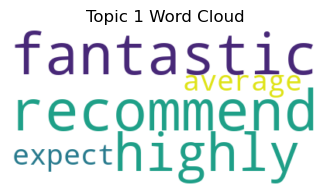

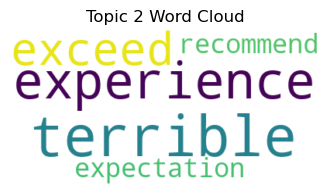

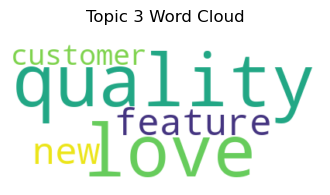

In [3]:
# Sentiment Analysis and Topic modelling and Word cloud on them


# Sentiment Analysis
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['comments'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Text Preprocessing
nlp = spacy.load("en_core_web_sm")
def preprocess_text(text):
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

df['clean_comments'] = df['comments'].apply(preprocess_text)

# Vectorize Text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['clean_comments'])

# Fit LDA model
num_topics=3
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Assign topics to comments
topics = lda_model.transform(dtm)
df['topic'] = topics.argmax(axis=1)
# Function to display top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display top words for each topic
no_top_words = 5  # Number of top words to display per topic
feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, no_top_words)

# Create Word Cloud for each topic
def create_word_cloud(lda_model, feature_names, topic_idx):
    topic = lda_model.components_[topic_idx]
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    plt.figure(figsize=(4, 3))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Topic {topic_idx + 1} Word Cloud")
    plt.show()

# Create word cloud for each topic
for topic_idx in range(num_topics):
    create_word_cloud(lda_model, feature_names, topic_idx)


first_touch attribution:       user_id  touchpoint  attribution
0          1   fdbk_txt2  first_touch
1          3   fdbk_txt1  first_touch
2          4  socmed_ad2  first_touch
3          5  email_clk2  first_touch
4          6   fdbk_txt1  first_touch
..       ...         ...          ...
863      995  email_clk2  first_touch
864      997   fdbk_txt2  first_touch
865      998  email_clk2  first_touch
866      999   fdbk_txt2  first_touch
867     1000  email_clk3  first_touch

[868 rows x 3 columns]
last_touch attribution:       user_id  touchpoint attribution
0          1   fdbk_txt2  last_touch
1          3   fdbk_txt1  last_touch
2          4   fdbk_txt2  last_touch
3          5  email_clk3  last_touch
4          6   fdbk_txt1  last_touch
..       ...         ...         ...
863      995  email_clk2  last_touch
864      997   fdbk_txt1  last_touch
865      998  socmed_ad3  last_touch
866      999   fdbk_txt2  last_touch
867     1000  email_clk3  last_touch

[868 rows x 3 columns]
d

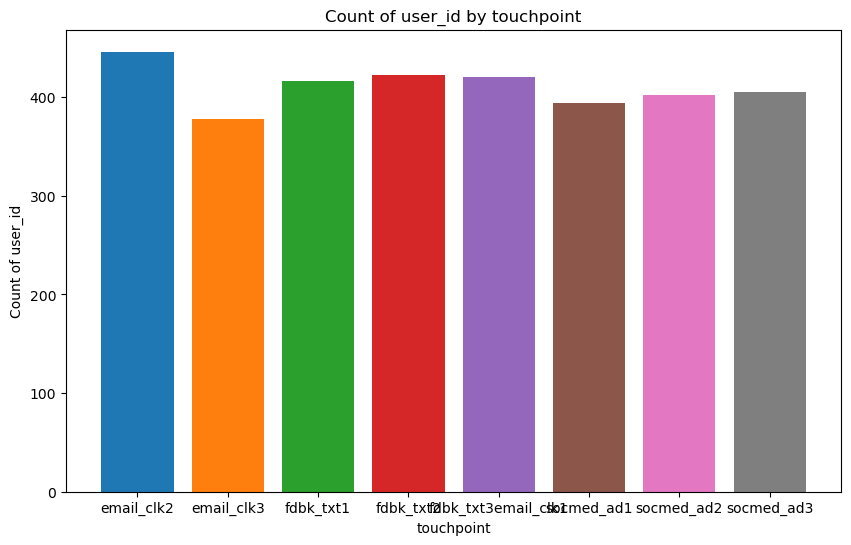

In [4]:
# Perform conversion touch attribution - first, last, exponentail decay

def first_touch_attribution(df):
    first_touch = df[df['conversion'] == 1].groupby('user_id').first().reset_index()
    first_touch = first_touch[['user_id', 'touchpoint']]
    first_touch['attribution'] = 'first_touch'
    return first_touch

def last_touch_attribution(df):
    last_touch = df[df['conversion'] == 1].groupby('user_id').last().reset_index()
    last_touch = last_touch[['user_id', 'touchpoint']]
    last_touch['attribution'] = 'last_touch'
    return last_touch

def exponential_decay_attribution(df, decay_factor=0.5):
    # Calculate decay weights
    df['decay_weight'] = df.groupby('user_id')['timestamp'].rank(ascending=False, method='first')
    df['decay_weight'] = df['decay_weight'].apply(lambda x: decay_factor ** (x - 1))

    # Filter out only conversion events
    conversion_df = df[df['conversion'] == 1]

    # Group by user_id and touchpoint, summing only decay_weight and sales_amount
    decay_attribution = conversion_df.groupby(['user_id', 'touchpoint']).agg({'decay_weight': 'sum', 'sales_amount': 'sum'}).reset_index()
    decay_attribution['attribution'] = 'exponential_decay'
    
    return decay_attribution

first_touch = first_touch_attribution(df)
last_touch = last_touch_attribution(df)
decay_attribution = exponential_decay_attribution(df)
print('first_touch attribution: ', first_touch)
print('last_touch attribution: ', last_touch)
print('decay_attribution attribution: ', decay_attribution)

group1 = first_touch.groupby(['touchpoint'])['user_id'].count().reset_index()
print("first_touch user_id count: ")
print(group1)
group2 = last_touch.groupby(['touchpoint'])['user_id'].count().reset_index()
print("last_touch user_id count: ")
print(group2)
group3 = decay_attribution.groupby(['touchpoint'])['user_id'].count().reset_index()
print("decay_attribution user_id count: ")
print(group3)

# Do Multi-Touch Attribution with Sentiment and Topic data already created above
def multi_touch_attribution_with_sentiment(df):
    conversions = df[df['conversion'] == 1].drop_duplicates(subset=['user_id'])
    multi_touch_credits = []

    for _, row in conversions.iterrows():
        user_id = row['user_id']
        conversion_time = row['timestamp']
        user_journey = df[(df['user_id'] == user_id) & (df['timestamp'] <= conversion_time)]
        
        if not user_journey.empty:
            touchpoints_count = len(user_journey)
            for _, touch in user_journey.iterrows():
                multi_touch_credits.append({
                    'user_id': user_id,
                    'touchpoint': touch['touchpoint'],
                    'credit': 1 / touchpoints_count,
                    'sentiment': touch['sentiment'],
                    'topic': touch['topic'],
                    'sales_amount': touch['sales_amount'],
                    'attribution': 'multi_touch'
                })
    
    return pd.DataFrame(multi_touch_credits)

multi_touch_attribution = multi_touch_attribution_with_sentiment(df)
print('multi_touch_attribution using Sentiment and Topic model: ', multi_touch_attribution)

group4 = multi_touch_attribution.groupby(['touchpoint'])['user_id'].count().reset_index()
print("multi_touch_attribution user_id count: ")
print(group4)

plt.figure(figsize=(10, 6))
for touchpoint, group in group4.groupby('touchpoint'):
    plt.bar(group['touchpoint'], group['user_id'], label=f'touchpoint {touchpoint}')

plt.xlabel('touchpoint')
plt.ylabel('Count of user_id')
plt.title('Count of user_id by touchpoint')
plt.show()


MSE:107490.8174, RMSE:327.8579, MAE:275.5222, R2:-0.1532


<Axes: >

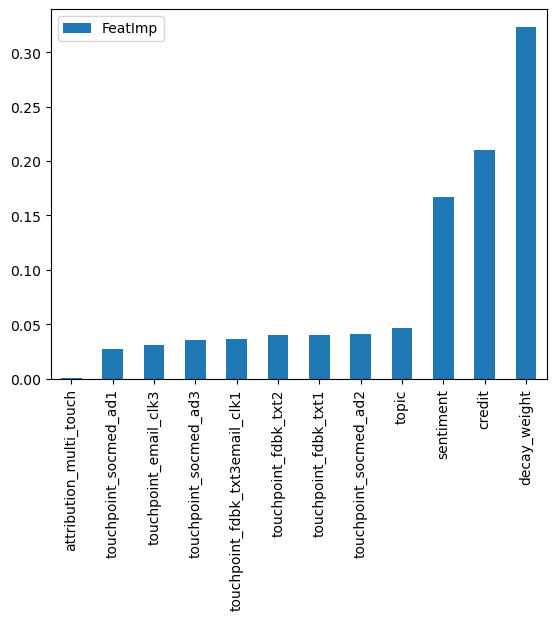

In [5]:
# Perform RandomForest Regression on attribution data and find attribute importance in predicting future sales
attribution_data = pd.concat([multi_touch_attribution, decay_attribution], ignore_index=True)

# Replace NaN values with 0
attribution_data.fillna(0, inplace=True)

# One-hot encoding for touchpoints and attribution types
attribution_data = pd.get_dummies(attribution_data, columns=['touchpoint', 'attribution'], drop_first=True)

# Features and target variable
X = attribution_data.drop(columns=['user_id', 'sales_amount'])
y = attribution_data['sales_amount']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a RandomForestRegressor estimator
estimator = RandomForestRegressor()
estimator.fit(X_train, y_train)

# Predict sales amount
y_pred = estimator.predict(X_test)

# Evaluate the model
# Calculate error metrics for predicted y values vs y test data
mse = mean_squared_error(y_test , y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test , y_pred)
r2 = r2_score(y_test , y_pred)
print('MSE:%.4f, RMSE:%.4f, MAE:%.4f, R2:%.4f' %(mse, rmse, mae, r2))


#Feature Importance
rfimp = estimator.feature_importances_
featimp = pd.DataFrame(rfimp)
featimp = featimp.rename({0:'FeatImp'}, axis='columns')
featimp.index = X.columns[0:]
featimp = featimp.sort_values(by=['FeatImp'])
featimp.plot(kind='bar')


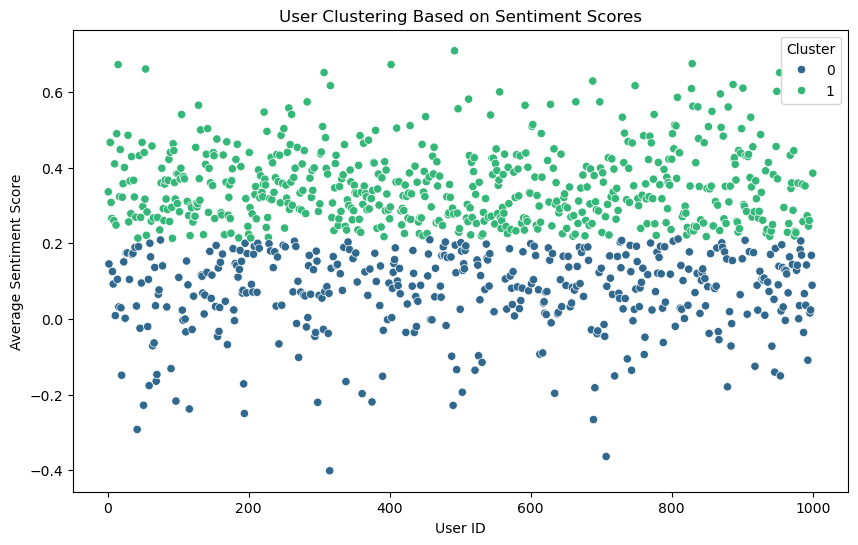

Positive Cluster: 
   user_id  sentiment  cluster
0        1   0.336140        1
2        3   0.467783        1
3        4   0.466360        1
4        5   0.308063        1
5        6   0.265800        1
Negative Cluster: 
    user_id  sentiment  cluster
1         2   0.145380        0
6         7   0.125510        0
7         8   0.092433        0
10       11   0.008978        0
13       14   0.104855        0


In [6]:
# Perform Clustering using K-Means based on sentiment scores - can use any other feature
user_sentiment = df.groupby('user_id')['sentiment'].mean().reset_index()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
user_sentiment['cluster'] = kmeans.fit_predict(user_sentiment[['sentiment']])

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_sentiment, x='user_id', y='sentiment', hue='cluster', palette='viridis')
plt.title('User Clustering Based on Sentiment Scores')
plt.xlabel('User ID')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Cluster')
plt.show()

# Analyze the clusters
positive_cluster = user_sentiment[user_sentiment['cluster'] == 1]
negative_cluster = user_sentiment[user_sentiment['cluster'] == 0]

print("Positive Cluster: ")
print(positive_cluster.head())

print("Negative Cluster: ")
print(negative_cluster.head())